# Data Exploration

## Preperation

### Imports

In [ ]:
# Download and import of German Stopwords, execution only needed once
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

In [1]:
# All necessary imports
import pandas as pd
import numpy as np
# import time
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from matplotlib.colors import LogNorm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from langdetect import detect, DetectorFactory
from ast import literal_eval
from fuzzywuzzy import fuzz

### Data prep

In [9]:
# Loading synonyms into a dataframe
kode = pd.read_excel("kode_data.xlsx", header=1)

# Keep one of the df commented:
columns = [ 'title', 
            'location', 
            'company',
            'job_dt',
            'year_month',
            'contract_type',
            'work_type',
            'pers_resp',
            'language',
            'introduction_clean_tokens', 
            'description_clean_tokens',
            'profile_clean_tokens', 
            'weoffer_clean_tokens']


# Reading full dataset into dataframe
df = pd.read_csv('jobs_tokenized.csv', encoding='UTF-8', usecols=columns)

# Reading sample dataset into dataframe
# df = pd.read_excel("jobs_sample.xlsx")

In [10]:
kode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     64 non-null     int64 
 1   coord     64 non-null     object
 2   quadrant  64 non-null     object
 3   name      64 non-null     object
 4   syn       64 non-null     object
 5   label     64 non-null     object
dtypes: int64(1), object(5)
memory usage: 3.1+ KB


In [4]:
df['job_dt'] = pd.to_datetime(df['job_dt'])
df['year_month'] = pd.to_datetime(df['year_month'])

In [51]:
# df['language'] = ['' for i in range(len(df))]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417109 entries, 0 to 417108
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   title                      417109 non-null  object        
 1   location                   417001 non-null  object        
 2   company                    416954 non-null  object        
 3   job_dt                     417109 non-null  datetime64[ns]
 4   year_month                 417109 non-null  datetime64[ns]
 5   contract_type              369405 non-null  object        
 6   work_type                  367390 non-null  object        
 7   pers_resp                  417109 non-null  int64         
 8   language                   417109 non-null  object        
 9   profile_clean_tokens       402253 non-null  object        
 10  introduction_clean_tokens  403466 non-null  object        
 11  description_clean_tokens   408901 non-null  object  

In [20]:
# Dropping english offers

DetectorFactory.seed = 0

for index, row in df.iterrows():
    try:
        language = detect(row['profile_clean'])
    except:
        pass

    df['language'] = language

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417109 entries, 0 to 417108
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   title               417109 non-null  object
 1   location            417001 non-null  object
 2   company             416954 non-null  object
 3   job_dt              417109 non-null  object
 4   year_month          417109 non-null  object
 5   contract_type       369405 non-null  object
 6   work_type           367390 non-null  object
 7   pers_resp           417109 non-null  int64 
 8   introduction_clean  403466 non-null  object
 9   description_clean   408901 non-null  object
 10  profile_clean       402253 non-null  object
 11  weoffer_clean       374449 non-null  object
 12  language            417109 non-null  object
dtypes: int64(1), object(12)
memory usage: 41.4+ MB


In [5]:
def tokenizer(frame, col):
    stop_words = set(stopwords.words('german'))
    new_col = f"{col}_tokens"
    frame[new_col] = ['' for j in range(len(frame))]

    for i, row in enumerate(frame[col]):
        try:
            tokens = word_tokenize(row, language="german")
            words = [w.lower()  for w in tokens
                                if not w.lower() in stop_words]
            frame.at[i, new_col] = words
        except:
            pass
    print(f'Tokenizing {col} done.')
    
    return None


In [58]:
# tokenizer(df, 'introduction_clean')
# tokenizer(df, 'description_clean')
# tokenizer(df, 'profile_clean')
# tokenizer(df, 'weoffer_clean')
# df.to_csv('jobs_tokenized.csv')

Tokenizing description_clean done.
Tokenizing profile_clean done.
Tokenizing weoffer_clean done.


In [13]:
tokenizer(df, 'title')

Tokenizing title done.


### Essential functions

In [6]:
# Count frequency of words in column
def countall(col):
    wcnt = Counter()

    for row in col:
        try:
            wcnt.update(literal_eval(row))
        except:
            pass

    return dict(wcnt.most_common())


# Create kode array w/ synonym count of countall()
def synarr(wcnt):
    arr = np.zeros(shape=(8,8))
    r64 = range(64)
    dcnt = {i:0 for i in r64} # dict to count synonym value into
    synonyms = [(syn, i)    for i in r64 
                            for syn in literal_eval(kode['syn'][i])]
    for syn in synonyms:
        sylen = len(syn[0])
        for word in wcnt.keys(): 
            wlen = len(word)
            wlen_ul = wlen + 4
            wlen_ll = wlen - 3
            if wlen_ll <= sylen <= wlen_ul:
                ratio = fuzz.ratio(word.lower(), syn[0])
                if ratio > 80:
                    dcnt[syn[1]] += wcnt[word]
                    del wcnt[word]
                    break
            
    for i in r64:
        x,y = literal_eval(kode['coord'][i])
        arr[x-1][y-1] = dcnt[i]

    return arr


# Sum array into coarser definitions
def coarser(arr):
    cache = []
    result = []
    for j in range(8):
        cache.append([arr[j][i]+arr[j][i+1] for i in range(0, 8, 2)])

    for n in range(0, 8, 2):
        result.append([sum(k) for k in zip(cache[n], cache[n+1])])
        
    return np.array(result)



## Data Analysis

### Work type distribution

Vollzeit       344826
Teilzeit        22521
Home Office        43
Name: work_type, dtype: int64


Text(0.5, 1.0, 'work_type Verteilung in %')

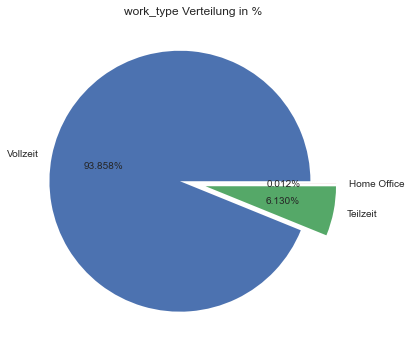

In [4]:
# Auf welcher Basis wird Arbeit geboten (Vollzeit, etc.)?

worktype_cnt = df['work_type'].value_counts()
print(worktype_cnt)

pie, ax = plt.subplots(figsize=[10,6])
pie.set_facecolor('white')
plt.pie(worktype_cnt, autopct="%.3f%%", explode=[0.1]*3, labels=worktype_cnt.keys())
plt.title("work_type Verteilung in %")


In [4]:
# Finding 'home office' benefit in weoffer column
weoffer = countall(df['weoffer_clean_tokens'])


Count 'home' and 'office' in weoffer, to evaluate possible frequency of home office capability offered:

In [37]:
# List of boolean for if 'home' and 'office' in row
HO_count = [    'home' in literal_eval(row) 
                and 'office' in literal_eval(row) 
                for row in df[~df['weoffer_clean_tokens'].isnull()]
                ['weoffer_clean_tokens']]

print(f"Home office might be mentioned {sum(HO_count)} times.")
    

14183

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417109 entries, 0 to 417108
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   title                      417109 non-null  object
 1   location                   417001 non-null  object
 2   company                    416954 non-null  object
 3   job_dt                     417109 non-null  object
 4   year_month                 417109 non-null  object
 5   contract_type              369405 non-null  object
 6   work_type                  367390 non-null  object
 7   pers_resp                  417109 non-null  int64 
 8   language                   417109 non-null  object
 9   profile_clean_tokens       402253 non-null  object
 10  introduction_clean_tokens  403466 non-null  object
 11  description_clean_tokens   408901 non-null  object
 12  weoffer_clean_tokens       374449 non-null  object
dtypes: int64(1), object(12)
memory usage: 41.4+ 

##Location mapping

###Map testing and prep

In [5]:
location_cnt = df['location'].value_counts()
loc_cnt_dict = {}

for place in location_cnt.keys():
    if ',' in place:
        for single in place.split(','):
            if single.strip() in loc_cnt_dict:
                loc_cnt_dict[single.strip()] += location_cnt[place]
            else:
                loc_cnt_dict[single] = location_cnt[place]
    else:
        if place in loc_cnt_dict:
            loc_cnt_dict[place] += location_cnt[place]
        else:
            loc_cnt_dict[place] = location_cnt[place]

loc_cnt_sorted = sorted(loc_cnt_dict.items(), key=lambda x:x[1], reverse=True)

# print(loc_cnt_dict)

In [6]:
import geopandas as gpd

plz_shape = gpd.read_file('germany/plz-gebiete.shp/plz-gebiete.shp', dtype={'plz': str})
plz_region = pd.read_csv('germany/zuordnung_plz_ort.csv', sep=',', dtype={'plz': str})
plz_region.drop('osm_id', axis=1, inplace=True)
top_cities = {}

# for index, row in germany.iterrows():
#     top_cities[row['city']] = (row['lng'], row['lat'])



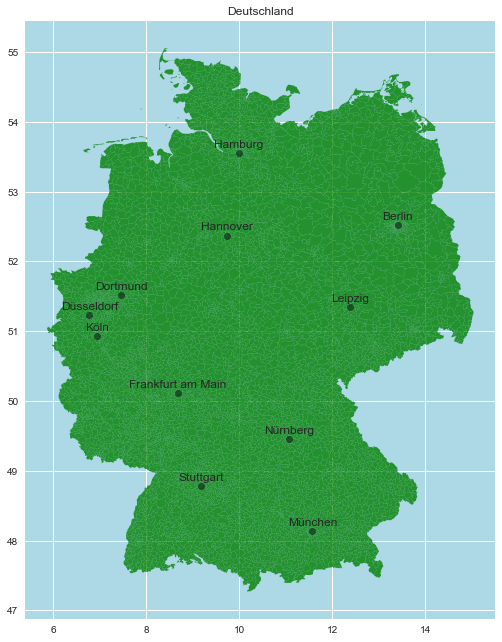

In [7]:
# Following segment is taken and adjusted from https://juanitorduz.github.io/germany_plots/
plt.rcParams['figure.figsize'] = [22, 11]

# Get lat and lng of Germany's main cities. 
top_cities = {
    'Berlin': (13.404954, 52.520008), 
    'Köln': (6.953101, 50.935173),
    'Düsseldorf': (6.782048, 51.227144),
    'Frankfurt am Main': (8.682127, 50.110924),
    'Hamburg': (9.993682, 53.551086),
    'Leipzig': (12.387772, 51.343479),
    'München': (11.576124, 48.137154),
    'Dortmund': (7.468554, 51.513400),
    'Stuttgart': (9.181332, 48.777128),
    'Nürnberg': (11.077438, 49.449820),
    'Hannover': (9.73322, 52.37052)
}

fig, ax = plt.subplots()

plz_shape.plot(ax=ax, color='green', alpha=0.8)

# Plot cities. 
for c in top_cities.keys():
    # Plot city name.
    ax.text(
        x=top_cities[c][0], 
        # Add small shift to avoid overlap with point.
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )
    # Plot city location centroid.
    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )

ax.set(
    title='Deutschland', 
    aspect=1.5, 
    facecolor='lightblue'
);

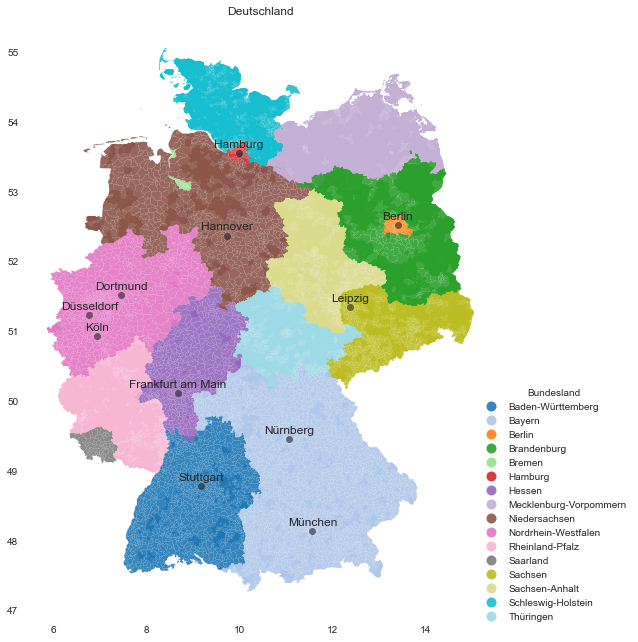

In [8]:
germany_df = pd.merge(
    left=plz_shape, 
    right=plz_region, 
    on='plz',
    how='inner'
)

germany_df.drop(['note'], axis=1, inplace=True)

fig, ax = plt.subplots()

germany_df.plot(
    ax=ax, 
    column='bundesland', 
    categorical=True, 
    legend=True, 
    legend_kwds={'title':'Bundesland', 'bbox_to_anchor': (1.3, 0.4)},
    cmap='tab20',
    alpha=0.9
)

for c in top_cities.keys():

    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )

ax.set(
    title='Deutschland', 
    aspect=1.5, 
    facecolor='white'
);

plt.rcParams['figure.figsize'] = [20, 15]

In [9]:

germany_df['jobcount'] = [0 for i in range(len(germany_df))]

for city in loc_cnt_sorted:
    try:
        if germany_df['ort'].str.contains(city[0]).any():
            index = germany_df[germany_df['ort']==city[0]].index
            germany_df.loc[index, 'jobcount'] = city[1]
    except:
        pass


C:\Users\SHARAV~1.SUB\AppData\Local\Temp/ipykernel_7260/286760129.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if germany_df['ort'].str.contains(city[0]).any():


In [10]:
germany_df.head()

,plz,geometry,ort,bundesland,jobcount
0,52538,"POLYGON ((5.86632 51.05110, 5.86692 51.05124, ...",Gangelt,Nordrhein-Westfalen,2
1,52538,"POLYGON ((5.86632 51.05110, 5.86692 51.05124, ...",Selfkant,Nordrhein-Westfalen,0
2,47559,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ...",Kranenburg,Nordrhein-Westfalen,0
3,52525,"POLYGON ((5.96811 51.05556, 5.96951 51.05660, ...",Heinsberg,Nordrhein-Westfalen,80
4,52525,"POLYGON ((5.96811 51.05556, 5.96951 51.05660, ...",Waldfeucht,Nordrhein-Westfalen,0


###Actual map plotting

In [11]:
germany_df.drop_duplicates(subset='ort', keep='last')
bundesland_df = germany_df.groupby(['bundesland'])[['jobcount']].sum()

for bundesland in bundesland_df.index:
    index = germany_df[germany_df['bundesland']==bundesland].index
    germany_df.loc[index, 'jobcount'] = bundesland_df.loc[bundesland]['jobcount']



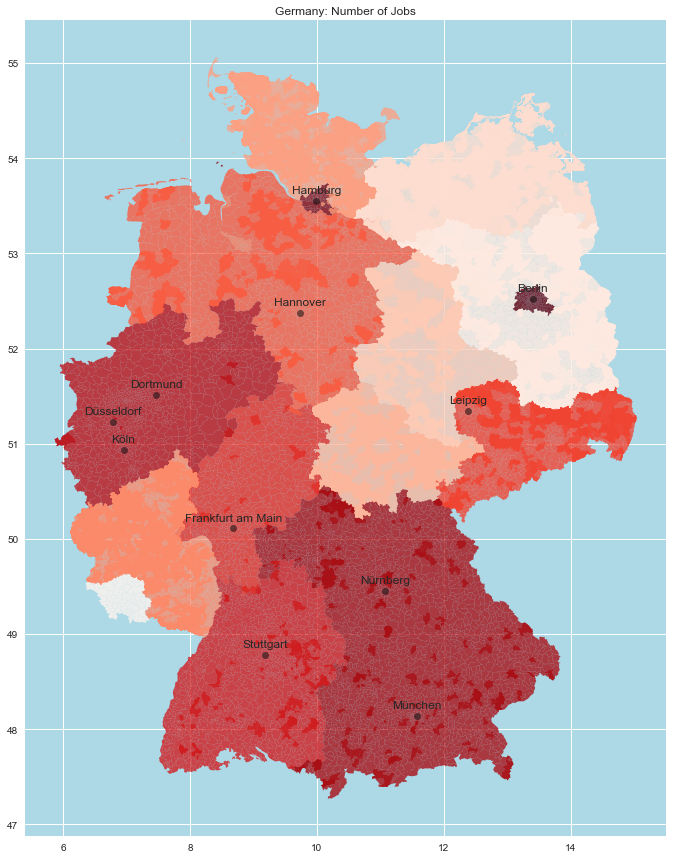

In [13]:
fig, ax = plt.subplots()

germany_df.plot(
    ax=ax, 
    column='jobcount', 
    categorical=True, 
    # legend=germany_df['bundesland'], 
    cmap='Reds',
    alpha=0.8
)

# germany_df.plot(
#     ax=ax, 
#     column='bundesland', 
#     categorical=True, 
#     legend=True, 
#     legend_kwds={'title':'Bundesland', 'bbox_to_anchor': (1.3, 0.4)},
#     cmap='tab20',
#     alpha=0.9
# )

for c in top_cities.keys():

    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )
    
ax.set(
    title='Germany: Number of Jobs', 
    aspect=1.5, 
    facecolor='lightblue'
);

##Top 20 companies (by offer frequency)

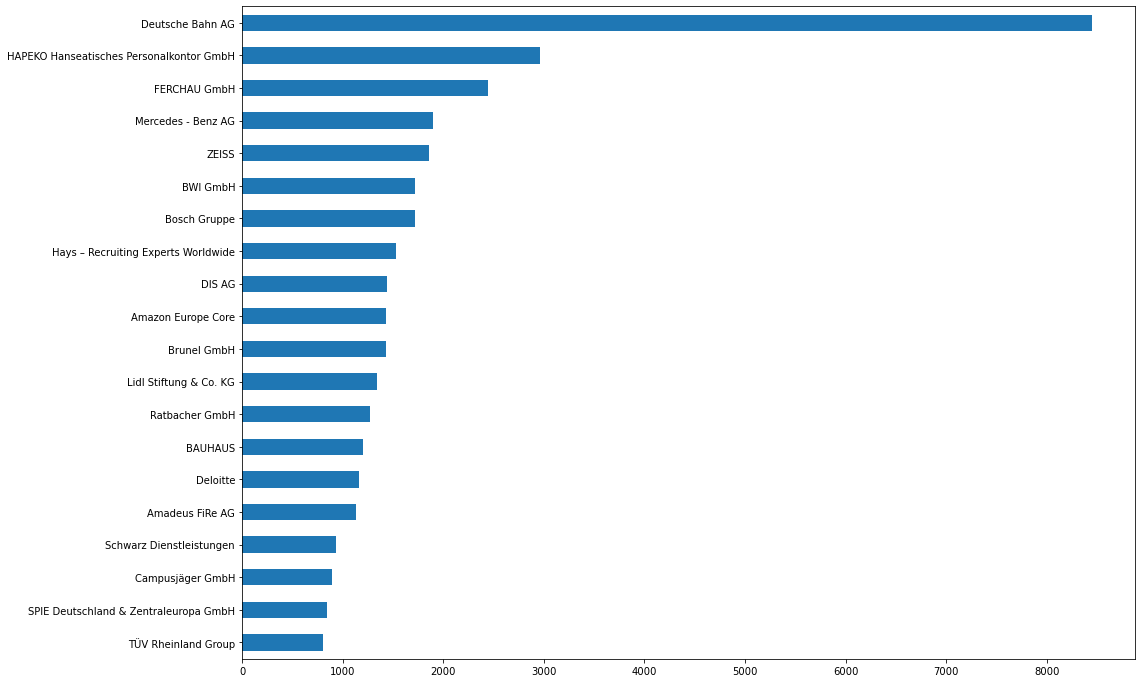

In [6]:
top_company_cnt = df['company'].value_counts()
top20 = top_company_cnt.head(25)
for company in top20.keys():
    if 'Presented' in company:
        top20.drop(company, inplace=True)
top20.head(20).plot.barh()
plt.gca().invert_yaxis()
plt.rcParams['figure.figsize'] = (16, 12)

##Wordcloud prep

In [53]:
mask = df['company'] == 'Deutsche Bahn AG'
bahn_ag = countall(df[mask]['weoffer_clean_tokens'])
bahn_ag = dict(bahn_ag)
remov = ['sowie', 'd', 'i', 'r', '–', 'zurueck', 'fach','betriebliche', 'schaffst']
for key in remov:
    del bahn_ag[key]
print(bahn_ag)

{'benefits': 8267, 'projekt': 7804, 'altersvorsorge': 7629, 'beschaeftigungssicherung': 7607, 'nebenleistungen': 7590, 'gehaltspaket': 7567, 'vielfaeltige': 7525, 'unbefristeten': 7520, 'bekommst': 7518, 'marktuebliches': 7518, 'arbeitsvertraegen': 7518, 'fuehrungsebene': 7443, 'langfristige': 7442, 'individuelle': 7404, 'perspektive': 4705, 'grosses': 4630, 'weniger': 4630, 'geben': 4458, 'weiterentwicklungsmoeglichkeiten': 4440, 'gezielte': 4401, 'warten': 4252, 'faszinierende': 4241, 'projekte': 4241, 'aufgaben': 4241, 'fordern': 4237, 'koennen': 4237, 'handschrift': 4237, 'bieten': 3435, 'kleineren': 3058, 'trainings': 3044, 'qualifizierungen': 3044, 'entwicklungs': 3044, 'aufstiegschancen': 3044, 'augenhoehe': 3042, 'seminaren': 3003, 'ebenso': 2985, 'zuhause': 2983, 'grossen': 2981, 'begegnen': 2977, 'regel': 2977, 'arbeitsplaetzen': 2977, 'bundesland': 2977, 'staedten': 2977, 'ortschaften': 2977, 'gemeinden': 2977, 'immer': 2907, 'deshalb': 2907, 'gibst': 2888, 'spannenden': 239

## Competencies

### Overall look

In [25]:
# wcnt = countall(df['profile_clean_tokens'])
# arr = synarr(wcnt)


# goho = coarser(arr)
kode16_label = np.array(
    [['P', 'P/A', 'A/P', 'A'],
    ['P/S', 'P/F', 'A/S', 'A/F'],
    ['S/P', 'S/A', 'F/P', 'F/A'],
    ['S', 'S/F', 'F/S', 'F']])

def kode_matrix(array, ax=None, label=True, cb=None):  
    smap = sns.heatmap(array, 
                annot=label, 
                vmin=0,
                vmax=1,
                fmt = '', 
                linewidths=1, 
                linecolor='w', 
                square=True, 
                norm=LogNorm(), # log scale to account for big decrepencies
                cmap='flare',
                ax=ax,
                xticklabels=False,
                yticklabels=False,
                cbar_ax=cb)
    
    return smap

# kode_matrix(goho)

In [41]:
kodict = {}
for i in range(64):
        x,y = literal_eval(kode['coord'][i])
        kodict[kode['name'][i]] = arr[x-1][y-1]

print(sorted(kodict.items(), key=lambda item: item[1], reverse=True))

[('Expertise', 304438.0), ('Fleiß', 127900.0), ('Offenheit für Veränderungen', 125834.0), ('Teamfähigkeit', 122734.0), ('Kommunikationsfähigkeit', 74024.0), ('Mobilität', 56032.0), ('Lernfähigkeit', 53692.0), ('Werteorientierung', 42118.0), ('Initiative', 36701.0), ('Einsatzbereitschaft', 35384.0), ('Zuverlässigkeit', 34321.0), ('Belastbarkeit', 30884.0), ('Entscheidungsfähigkeit', 29354.0), ('Projektmanagement', 23162.0), ('Organisationsfähigkeit', 22774.0), ('Dialogfähigkeit', 19886.0), ('Eigenverantwortung', 17152.0), ('Humor', 15009.0), ('Schöpferische Fähigkeit', 12817.0), ('Beharrlichkeit', 11650.0), ('Zielorientiertes Führen', 10498.0), ('Gewissenhaftigkeit', 9984.0), ('Anpassungs-fähigkeit', 9443.0), ('Optimismus', 5297.0), ('Beratungsfähigkeit', 5178.0), ('Loyalität', 4296.0), ('Tatkraft', 4254.0), ('Verständnisfähigkeit', 4123.0), ('Mitarbeiterförderung', 3534.0), ('Analytische Fähigkeit', 3500.0), ('Lehrfähigkeit', 3476.0), ('Ergebnisorientiertes Handeln', 3404.0), ('Experim

[[ 2062.  4497.  1097.  2903.]
 [  460.  1844.   255.   881.]
 [ 4858.   614.   184.  4411.]
 [ 2817.   253.  2339. 14213.]]


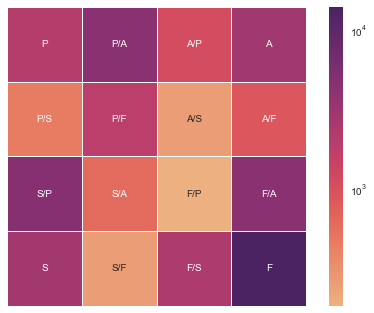

In [14]:
selection = ['senior']
mask = df['title_tokens'].apply(lambda x: any(item for item in selection if item in x))
senior = countall(df[mask]['profile_clean_tokens'])

senior_arr = synarr(senior)


senior_coarse = coarser(senior_arr)
kode_matrix(senior_coarse)
print(senior_coarse)

[[1140. 3237.  611. 1614.]
 [ 187. 1175.  169.  465.]
 [2702.  236.  114. 3256.]
 [1781.  183.  874. 5388.]]


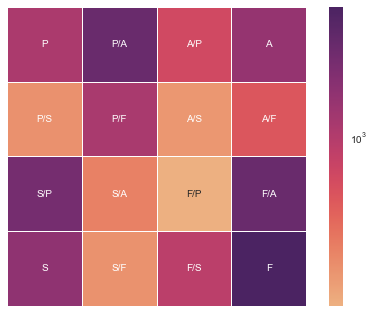

In [15]:
selection = ['junior']
mask = df['title_tokens'].apply(lambda x: any(item for item in selection if item in x))
junior = countall(df[mask]['profile_clean_tokens'])

junior_arr = synarr(junior)


junior_coarse = coarser(junior_arr)
kode_matrix(junior_coarse)
print(junior_coarse)

In [ ]:

mask_20q2 = df[(df['year_month'] > '2020-03-31') & (df['year_month'] < '2020-07-01')]
q2_20 = countall(mask_20q2['profile_clean_tokens'])
q2_20_arr = synarr(q2_20)
q2_20_coarse = coarser(q2_20_arr)

mask_20q3 = df[(df['year_month'] > '2020-06-30') & (df['year_month'] < '2020-10-01')]
q3_20 = countall(mask_20q3['profile_clean_tokens'])
q3_20_arr = synarr(q3_20)
q3_20_coarse = coarser(q3_20_arr)

mask_20q4 = df[(df['year_month'] > '2020-09-30') & (df['year_month'] < '2021-01-01')]
q4_20 = countall(mask_20q4['profile_clean_tokens'])
q4_20_arr = synarr(q4_20)
q4_20_coarse = coarser(q4_20_arr)

mask_21q1 = df[(df['year_month'] > '2020-12-31') & (df['year_month'] < '2021-04-01')]
q1_21 = countall(mask_21q1['profile_clean_tokens'])
q1_21_arr = synarr(q1_21)
q1_21_coarse = coarser(q1_21_arr)


<AxesSubplot:>

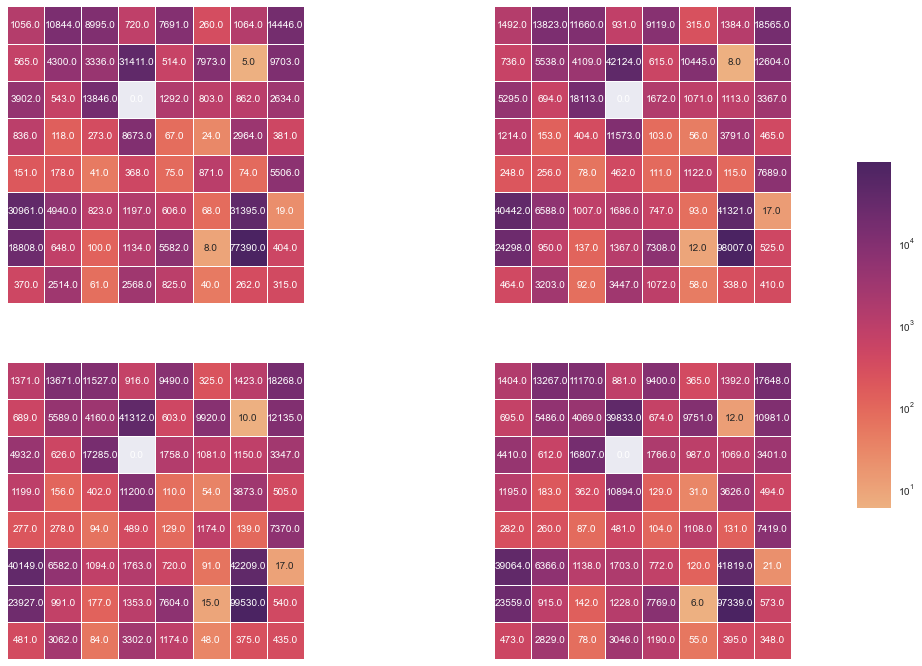

In [30]:

fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 12))
cbar_ax = fig.add_axes([.91, .3, .03, .4])


kode_matrix(q2_20_arr, ax, cb=cbar_ax)
kode_matrix(q3_20_arr, ax2, cb=cbar_ax)
kode_matrix(q4_20_arr, ax3, cb=cbar_ax)
kode_matrix(q1_21_arr, ax4, cb=cbar_ax)



## Word Clouds and more

In [6]:
def count_noeval(col):
    wcnt = Counter()

    for row in col:
        try:
            wcnt.update(row)
        except:
            pass

    return dict(wcnt.most_common())

In [7]:
d_unfiltered = count_noeval(df['title_tokens'])
d = {k: v for k, v in d_unfiltered.items() if k.isalpha()}


In [34]:
from wordcloud import WordCloud, STOPWORDS

text1 = [f"{k} "*v for k, v in d.items()]
text2 = ''.join(text1)



In [30]:
STOPWORDS.update(['bereich', 'schwerpunkt', 'gute', 'sowie', 'hast', 
                    'fuer', 'erste', 'ueber', 'wort', 'm', 
                    'idealerweise', 'gerne', 'hohe', 'abgeschlossene',
                    'ausgepraegte'])


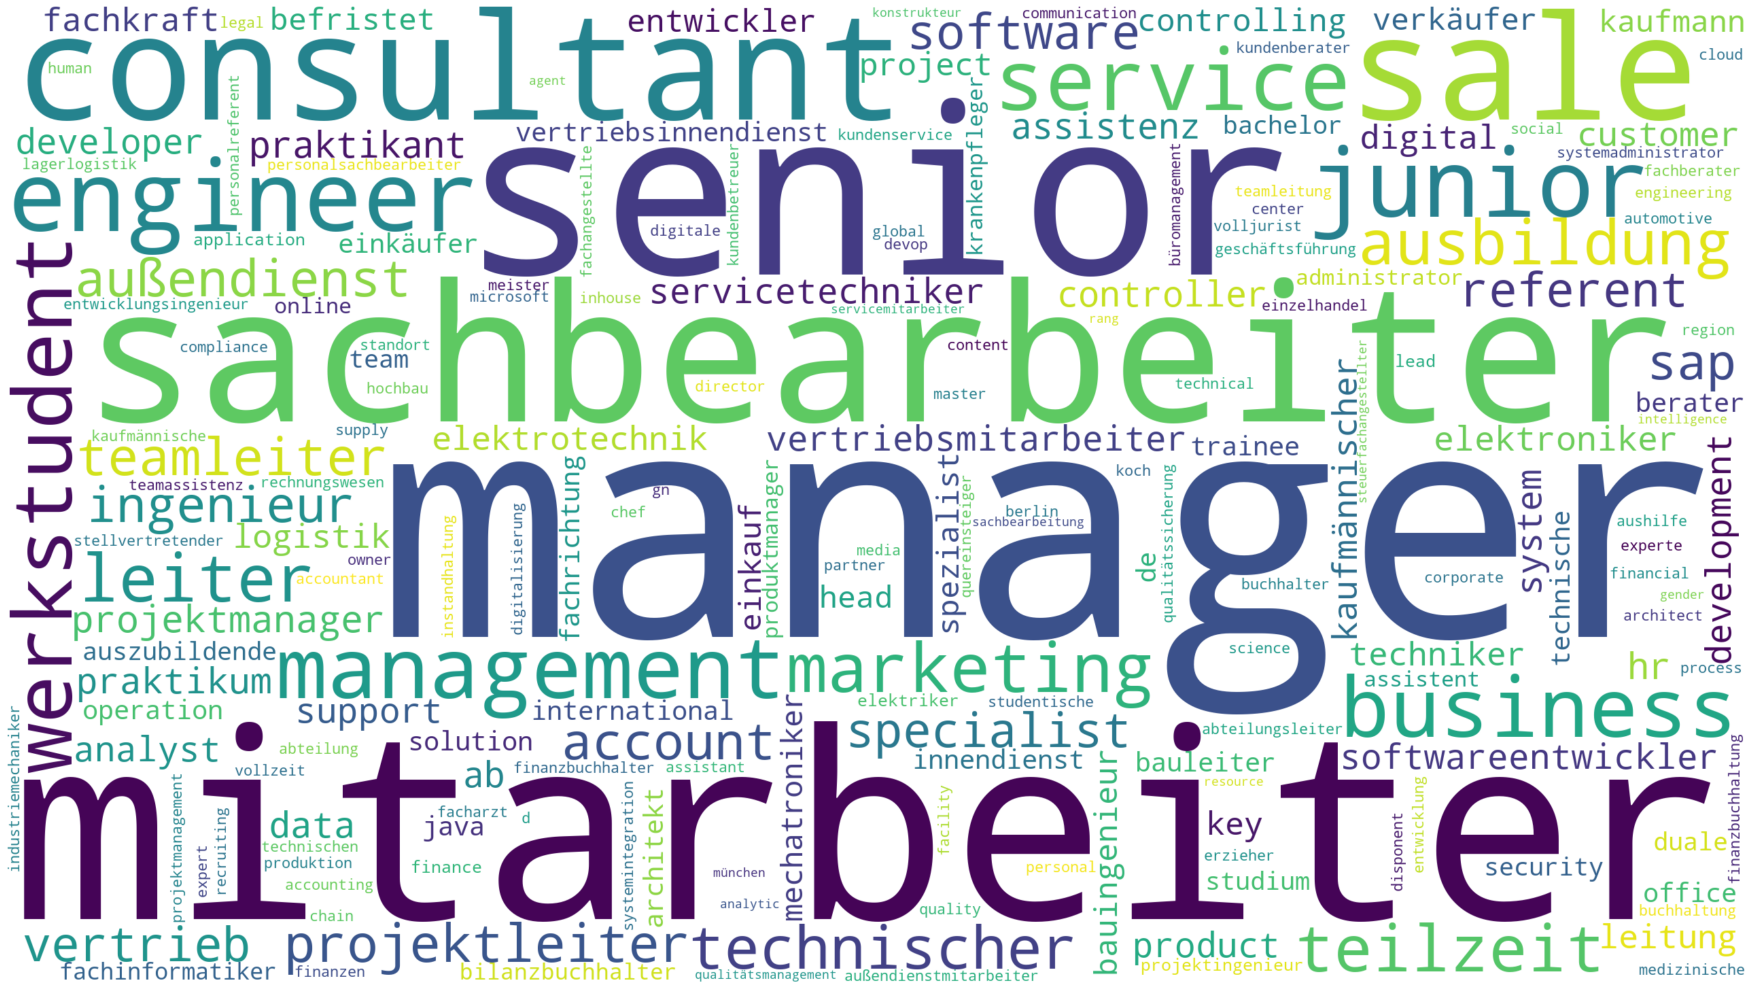

In [35]:
def cloudy(text):
    cloud = WordCloud(background_color="white", 
                        width=2560, height=1440, 
                        collocations=False).generate(text)

    plt.figure(figsize=(32,18))
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    return None

cloudy(text2)

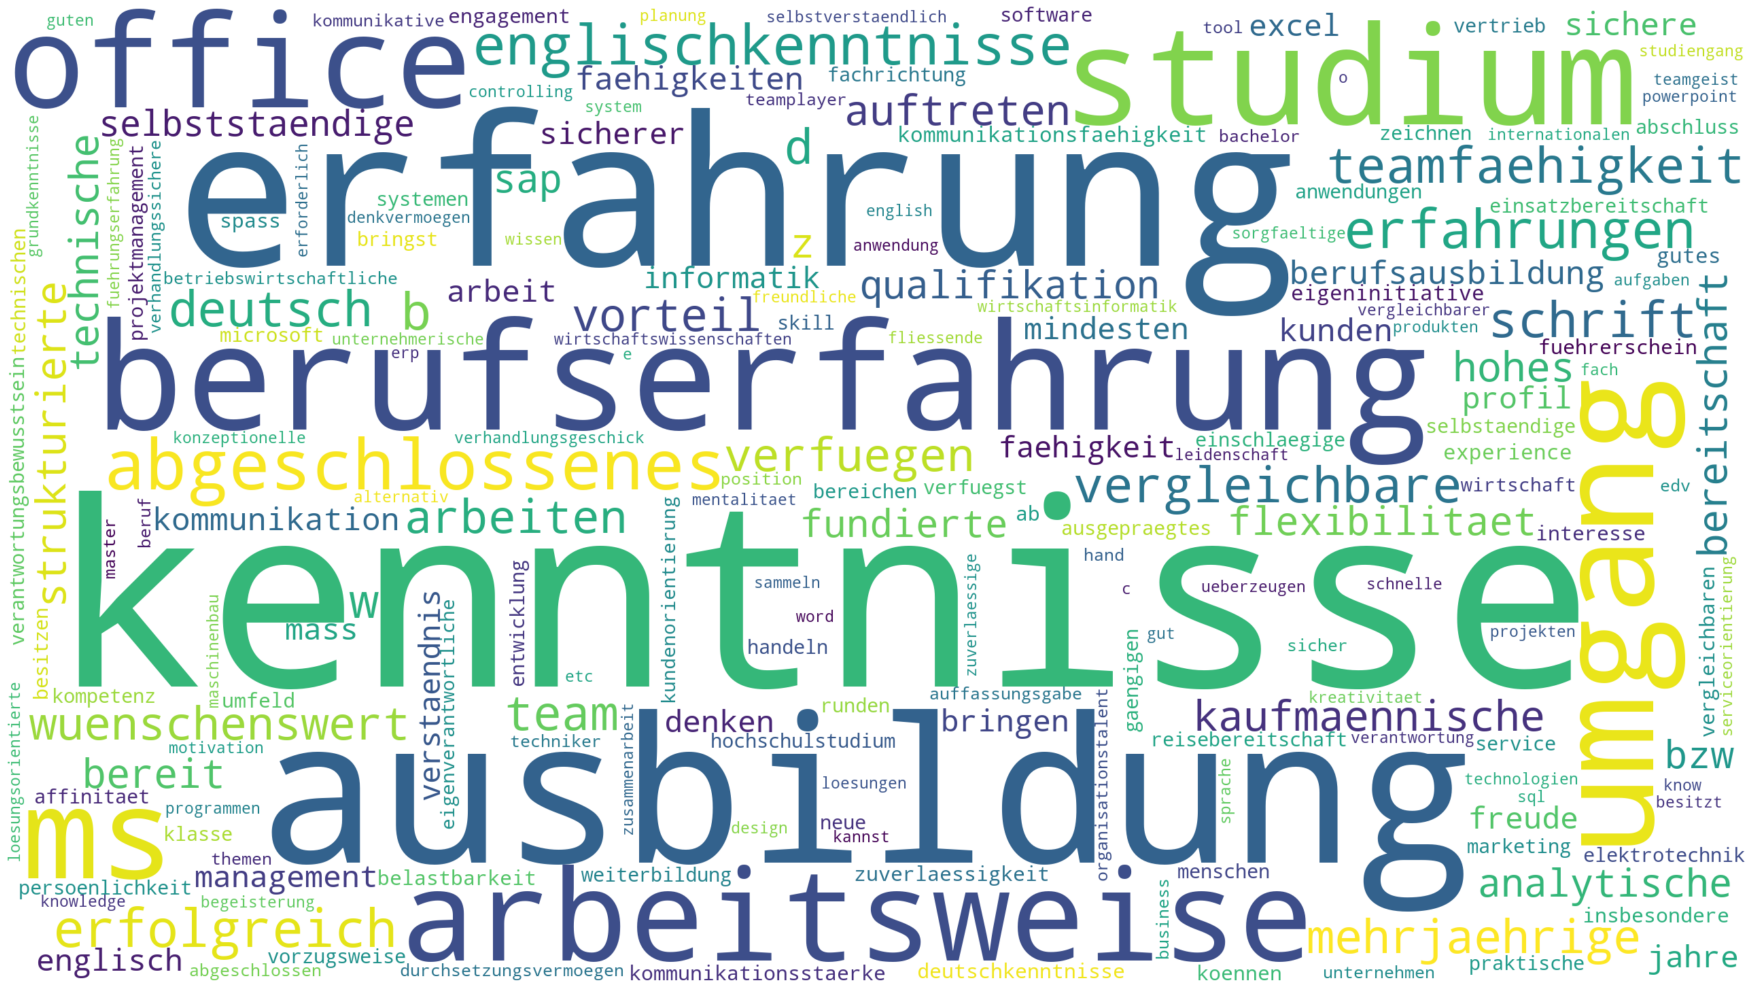

In [32]:
profile = countall(df['profile_clean_tokens'])

text1 = [f"{k} "*v for k, v in profile.items()]
text2 = ''.join(text1)

cloudy(text2)